1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1: airliner (score: 0.9994)
2: wing (score: 0.0004)
3: airship (score: 0.0001)
4: warplane (score: 0.0000)
5: space_shuttle (score: 0.0000)


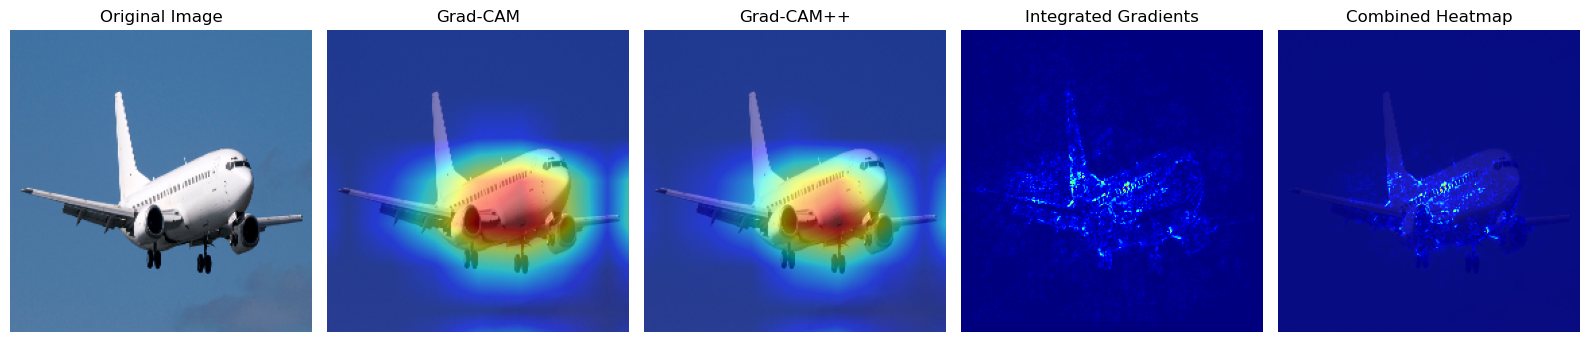

C:\Users\sanje\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\sanje\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\sanje\AppData\Local\Temp\ipykernel_10180\2940332207.py:248: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(representative_nodes))


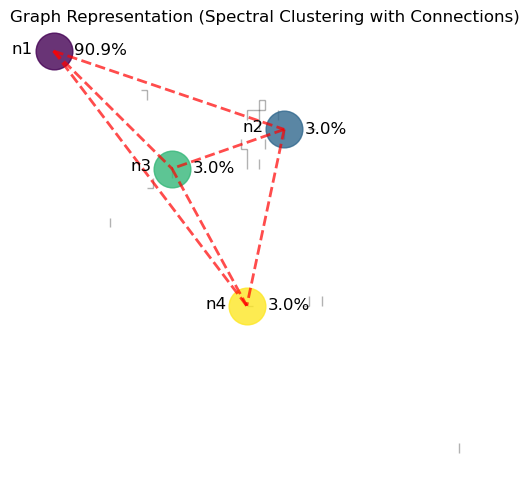

In [2]:
# =============================================================================
# Author: Pubudu Sanjeewani Thihagoda Gamage
# Date: 20-09-2024
# Title: A Novel Graph-Based Framework for Understanding of Decision-Making Process in Deep Learning Models
# License: MIT License
# =============================================================================

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import SpectralClustering
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
import numpy as np
from skimage.transform import resize

# Load pre-trained ResNet50V2 model with classification head (include_top=True)
model = ResNet50V2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

# Load and preprocess the image
img_path = 'images/plane.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Get predictions
predictions = model.predict(x)

# Decode the top 5 predictions
top_preds = decode_predictions(predictions, top=5)[0]

# Print top 5 predictions
for i, (imagenet_id, label, score) in enumerate(top_preds):
    print(f"{i+1}: {label} (score: {score:.4f})")

class_idx = 404

# Compute Grad-CAM
def compute_gradcam(model, img_array, class_idx):
    # Select a convolutional layer suitable for Grad-CAM visualization
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer('conv5_block3_out').output, model.output]  # Using the last convolutional block
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        tape.watch(conv_outputs)
        class_output = predictions[:, class_idx]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(conv_outputs * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)

    return heatmap

# Compute Grad-CAM++
def compute_gradcam_plus_plus(model, img_array, class_idx):
    # Select a convolutional layer suitable for Grad-CAM++ visualization
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer('conv5_block3_out').output, model.output]  # Using the last convolutional block
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        tape.watch(conv_outputs)
        class_output = predictions[:, class_idx]

    grads = tape.gradient(class_output, conv_outputs)
    grads = tf.maximum(grads, 0)  

    # Compute second order gradients
    with tf.GradientTape() as tape2:
        tape2.watch(conv_outputs)
        class_output = predictions[:, class_idx]

    second_grads = tape2.gradient(class_output, conv_outputs)

    # Compute the weights for Grad-CAM++
    weights = tf.reduce_sum(tf.divide(grads ** 2, 2 * grads + tf.keras.backend.epsilon()), axis=(0, 1))

    # Compute the Grad-CAM++ heatmap
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(weights * conv_outputs, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / tf.reduce_max(heatmap)  # Normalize the heatmap

    return heatmap.numpy()

# Compute Integrated Gradients
def compute_integrated_gradients(model, img_array, class_idx, baseline=None, num_steps=50):
    if baseline is None:
        baseline = np.zeros_like(img_array)

    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)
    baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)

    alphas = np.linspace(0, 1, num_steps)
    grads = np.zeros_like(img_array)

    for alpha in alphas:
        interpolated_img = baseline + alpha * (img_array - baseline)
        with tf.GradientTape() as tape:
            tape.watch(interpolated_img)
            predictions = model(interpolated_img)
            class_output = predictions[:, class_idx]
        grads += tape.gradient(class_output, interpolated_img)

    avg_grads = grads / num_steps
    integrated_gradients = (img_array - baseline) * avg_grads
    integrated_gradients = np.sum(np.abs(integrated_gradients), axis=-1)
    integrated_gradients = integrated_gradients / np.max(integrated_gradients)

    return integrated_gradients

# Compute heatmaps
gradcam_heatmap = compute_gradcam(model, x, class_idx)
gradcam_plus_plus_heatmap = compute_gradcam_plus_plus(model, x, class_idx)
integrated_gradients_map = compute_integrated_gradients(model, x, class_idx)

# Resize heatmaps to match image dimensions
gradcam_heatmap_resized = resize(gradcam_heatmap, (224, 224), mode='reflect', anti_aliasing=True)
gradcam_plus_plus_heatmap_resized = resize(gradcam_plus_plus_heatmap, (224, 224), mode='reflect', anti_aliasing=True)

# Combine heatmaps
combined_heatmap = gradcam_heatmap_resized * integrated_gradients_map
combined_heatmap = np.clip(combined_heatmap, 0, 1)

# Remove extra dimensions if present
combined_heatmap = np.squeeze(combined_heatmap)

# Plot all heatmaps
plt.figure(figsize=(16, 8))

# Original image
plt.subplot(1, 5, 1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')

# Grad-CAM heatmap
plt.subplot(1, 5, 2)
plt.title('Grad-CAM')
plt.imshow(img)
plt.imshow(gradcam_heatmap_resized, cmap='jet', alpha=0.5)
plt.axis('off')

# Grad-CAM++ heatmap
plt.subplot(1, 5, 3)
plt.title('Grad-CAM++')
plt.imshow(img)
plt.imshow(gradcam_plus_plus_heatmap_resized, cmap='jet', alpha=0.5)
plt.axis('off')

# Integrated gradients heatmap
plt.subplot(1, 5, 4)
plt.title('Integrated Gradients')
plt.imshow(integrated_gradients_map[0], cmap='jet')
plt.axis('off')

# Combined heatmap
plt.subplot(1, 5, 5)
plt.title('Combined Heatmap')
plt.imshow(img)
plt.imshow(np.squeeze(combined_heatmap), cmap='jet', alpha=0.9)  
plt.axis('off')

plt.tight_layout()
plt.show()

# Create a graph from the combined heatmap
def create_graph_from_heatmap(heatmap, threshold=0.3):
    G = nx.Graph()
    height, width = heatmap.shape

    for i in range(height):
        for j in range(width):
            if heatmap[i, j] > threshold:  # Add nodes for heatmap values above threshold
                G.add_node((i, j), value=heatmap[i, j])
                # Connect to neighbors
                if i > 0 and heatmap[i-1, j] > threshold:  # Top neighbor
                    G.add_edge((i, j), (i-1, j))
                if j > 0 and heatmap[i, j-1] > threshold:  # Left neighbor
                    G.add_edge((i, j), (i, j-1))
                if i < height - 1 and heatmap[i+1, j] > threshold:  # Bottom neighbor
                    G.add_edge((i, j), (i+1, j))
                if j < width - 1 and heatmap[i, j+1] > threshold:  # Right neighbor
                    G.add_edge((i, j), (i, j+1))
    return G

# Function to cluster the graph using spectral clustering
def cluster_graph_spectral(G, n_clusters=4):
    adj_matrix = nx.to_numpy_array(G)
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
    labels = spectral.fit_predict(adj_matrix)
    partition = {node: label for node, label in zip(G.nodes(), labels)}
    return partition
   
# Create graph from the combined heatmap
G = create_graph_from_heatmap(combined_heatmap)

# Spectral clustering
partition_spectral = cluster_graph_spectral(G)

# Function to label only representative nodes as n1, n2, n3, etc.
def label_representative_nodes_as_n(representative_nodes):
    node_labels = {}
    for i, node in enumerate(representative_nodes):
        node_labels[node] = f'n{i+1}'  # Label representative nodes as n1, n2, ...
    return node_labels

# Function to visualize clustered graph with inter-cluster connections and correct node labels
def visualize_clustered_graph_with_connections_labeled(G, partition, title):
    plt.figure(figsize=(6, 6))
    pos = {(x, y): (y, -x) for x, y in G.nodes()}
    
    # Determine cluster sizes and representative nodes
    clusters = {}
    for node, cluster_id in partition.items():
        if cluster_id not in clusters:
            clusters[cluster_id] = []
        clusters[cluster_id].append(node)

    # Choose one representative node per cluster and calculate percentages
    representative_nodes = {}
    total_nodes = len(G.nodes())
    for cluster_id, nodes in clusters.items():
        representative_node = nodes[0]  # Select the first node as the representative
        representative_nodes[representative_node] = len(nodes) / total_nodes * 100  # Percentage of total nodes

    # Label only the representative nodes as n1, n2, n3, etc.
    node_labels = label_representative_nodes_as_n(representative_nodes)

    # Draw edges first
    nx.draw_networkx_edges(G, pos, alpha=0.3)

    # Draw nodes
    cmap = cm.get_cmap('viridis', len(representative_nodes))
    node_colors = [cmap(i) for i in range(len(representative_nodes))]
    for idx, (node, percentage) in enumerate(representative_nodes.items()):
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_size=700, node_color=[node_colors[idx]], alpha=0.8)
        
        # Shift the node labels slightly away from the nodes
        label_x_offset = -5  # Adjust this value to shift horizontally
        label_y_offset = 0.2  # Adjust this value to shift vertically

        # Annotate representative node with name (n1, n2, etc.)
        plt.text(pos[node][0] + label_x_offset, pos[node][1] + label_y_offset, node_labels[node],
                 fontsize=12, ha='center', va='center', color='black')
        
        # Shift the percentage values slightly further away from the node
        percentage_x_offset = 3.3  # Increase this to move the text further away horizontally
        percentage_y_offset = 0.05  # Increase this to move the text further away vertically

        # Annotate with percentage value next to the node
        plt.text(pos[node][0] + percentage_x_offset, pos[node][1] + percentage_y_offset, f'{percentage:.1f}%',
                 fontsize=12, ha='left', va='center')

    # Add inter-cluster connections (edges between representative nodes)
    for i, rep_node_1 in enumerate(representative_nodes):
        for j, rep_node_2 in enumerate(representative_nodes):
            if i < j:  # To avoid double-drawing edges
                plt.plot(
                    [pos[rep_node_1][0], pos[rep_node_2][0]], 
                    [pos[rep_node_1][1], pos[rep_node_2][1]], 
                    color='red', linestyle='--', linewidth=2, alpha=0.7
                )

    plt.title(title)
    plt.axis('off')
    plt.show()

# Visualize the spectral clustering with connections and labeled nodes
visualize_clustered_graph_with_connections_labeled(G, partition_spectral, 'Graph Representation (Spectral Clustering with Connections)')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1: fire_engine (score: 0.9999)
2: agaric (score: 0.0000)
3: trolleybus (score: 0.0000)
4: slot (score: 0.0000)
5: beach_wagon (score: 0.0000)


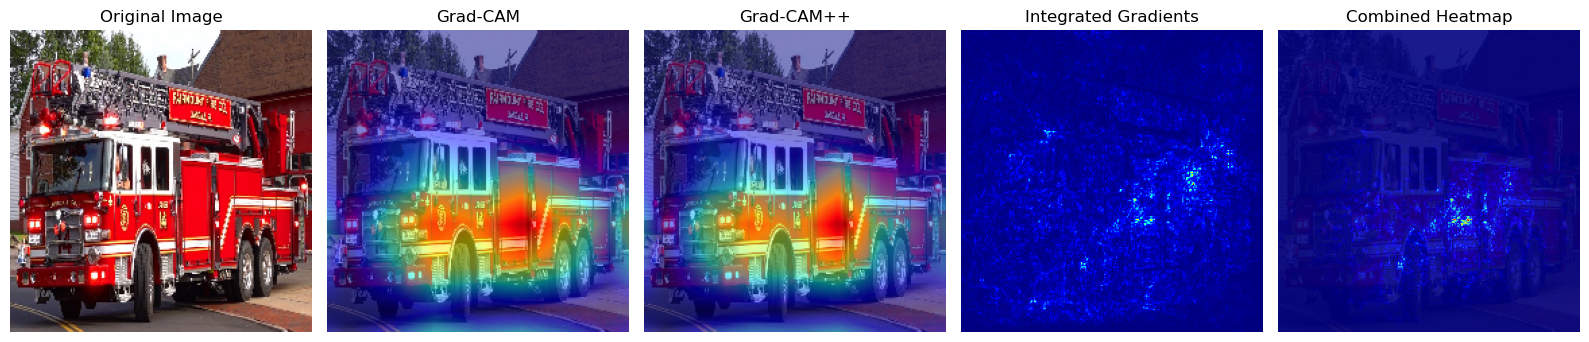

C:\Users\sanje\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\sanje\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\sanje\AppData\Local\Temp\ipykernel_10180\1731668806.py:248: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(representative_nodes))


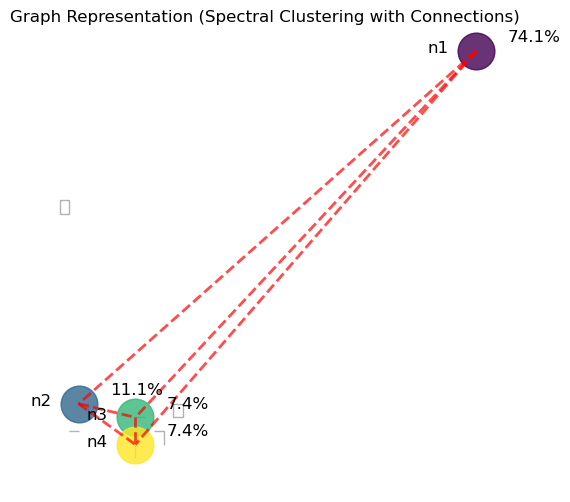

In [3]:
# =============================================================================
# Author: Pubudu Sanjeewani Thihagoda Gamage
# Date: 20-09-2024
# Title: A Novel Graph-Based Framework for Understanding of Decision-Making Process in Deep Learning Models
# License: MIT License
# =============================================================================

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import SpectralClustering
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
import numpy as np
from skimage.transform import resize

# Load pre-trained ResNet50V2 model with classification head (include_top=True)
model = ResNet50V2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

# Load and preprocess the image
img_path = 'images/fire truck.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Get predictions
predictions = model.predict(x)

# Decode the top 5 predictions
top_preds = decode_predictions(predictions, top=5)[0]

# Print top 5 predictions
for i, (imagenet_id, label, score) in enumerate(top_preds):
    print(f"{i+1}: {label} (score: {score:.4f})")

class_idx = 555

# Compute Grad-CAM
def compute_gradcam(model, img_array, class_idx):
    # Select a convolutional layer suitable for Grad-CAM visualization
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer('conv5_block3_out').output, model.output]  # Using the last convolutional block
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        tape.watch(conv_outputs)
        class_output = predictions[:, class_idx]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(conv_outputs * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)

    return heatmap

# Compute Grad-CAM++
def compute_gradcam_plus_plus(model, img_array, class_idx):
    # Select a convolutional layer suitable for Grad-CAM++ visualization
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer('conv5_block3_out').output, model.output]  # Using the last convolutional block
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        tape.watch(conv_outputs)
        class_output = predictions[:, class_idx]

    grads = tape.gradient(class_output, conv_outputs)
    grads = tf.maximum(grads, 0)  

    # Compute second order gradients
    with tf.GradientTape() as tape2:
        tape2.watch(conv_outputs)
        class_output = predictions[:, class_idx]

    second_grads = tape2.gradient(class_output, conv_outputs)

    # Compute the weights for Grad-CAM++
    weights = tf.reduce_sum(tf.divide(grads ** 2, 2 * grads + tf.keras.backend.epsilon()), axis=(0, 1))

    # Compute the Grad-CAM++ heatmap
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(weights * conv_outputs, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / tf.reduce_max(heatmap)  # Normalize the heatmap

    return heatmap.numpy()

# Compute Integrated Gradients
def compute_integrated_gradients(model, img_array, class_idx, baseline=None, num_steps=50):
    if baseline is None:
        baseline = np.zeros_like(img_array)

    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)
    baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)

    alphas = np.linspace(0, 1, num_steps)
    grads = np.zeros_like(img_array)

    for alpha in alphas:
        interpolated_img = baseline + alpha * (img_array - baseline)
        with tf.GradientTape() as tape:
            tape.watch(interpolated_img)
            predictions = model(interpolated_img)
            class_output = predictions[:, class_idx]
        grads += tape.gradient(class_output, interpolated_img)

    avg_grads = grads / num_steps
    integrated_gradients = (img_array - baseline) * avg_grads
    integrated_gradients = np.sum(np.abs(integrated_gradients), axis=-1)
    integrated_gradients = integrated_gradients / np.max(integrated_gradients)

    return integrated_gradients

# Compute heatmpas
gradcam_heatmap = compute_gradcam(model, x, class_idx)
gradcam_plus_plus_heatmap = compute_gradcam_plus_plus(model, x, class_idx)
integrated_gradients_map = compute_integrated_gradients(model, x, class_idx)

# Resize heatmaps to match image dimensions
gradcam_heatmap_resized = resize(gradcam_heatmap, (224, 224), mode='reflect', anti_aliasing=True)
gradcam_plus_plus_heatmap_resized = resize(gradcam_plus_plus_heatmap, (224, 224), mode='reflect', anti_aliasing=True)

# Combine heatmaps
combined_heatmap = gradcam_heatmap_resized * integrated_gradients_map
combined_heatmap = np.clip(combined_heatmap, 0, 1)

# Remove extra dimensions if present
combined_heatmap = np.squeeze(combined_heatmap)

# Plot all heatmaps 
plt.figure(figsize=(16, 8))

# Original image
plt.subplot(1, 5, 1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')

# Grad-CAM heatmap
plt.subplot(1, 5, 2)
plt.title('Grad-CAM')
plt.imshow(img)
plt.imshow(gradcam_heatmap_resized, cmap='jet', alpha=0.5)
plt.axis('off')

# Grad-CAM++ heatmap
plt.subplot(1, 5, 3)
plt.title('Grad-CAM++')
plt.imshow(img)
plt.imshow(gradcam_plus_plus_heatmap_resized, cmap='jet', alpha=0.5)
plt.axis('off')

# Integrated gradients map
plt.subplot(1, 5, 4)
plt.title('Integrated Gradients')
plt.imshow(integrated_gradients_map[0], cmap='jet')
plt.axis('off')

# Combined heatmap
plt.subplot(1, 5, 5)
plt.title('Combined Heatmap')
plt.imshow(img)
plt.imshow(np.squeeze(combined_heatmap), cmap='jet', alpha=0.9)  # Use np.squeeze to fix the shape
plt.axis('off')

plt.tight_layout()
plt.show()

# Create a graph from the combined heatmap
def create_graph_from_heatmap(heatmap, threshold=0.3):
    G = nx.Graph()
    height, width = heatmap.shape

    for i in range(height):
        for j in range(width):
            if heatmap[i, j] > threshold:  # Add nodes for heatmap values above threshold
                G.add_node((i, j), value=heatmap[i, j])
                # Connect to neighbors
                if i > 0 and heatmap[i-1, j] > threshold:  # Top neighbor
                    G.add_edge((i, j), (i-1, j))
                if j > 0 and heatmap[i, j-1] > threshold:  # Left neighbor
                    G.add_edge((i, j), (i, j-1))
                if i < height - 1 and heatmap[i+1, j] > threshold:  # Bottom neighbor
                    G.add_edge((i, j), (i+1, j))
                if j < width - 1 and heatmap[i, j+1] > threshold:  # Right neighbor
                    G.add_edge((i, j), (i, j+1))
    return G

# Function to cluster the graph using spectral clustering
def cluster_graph_spectral(G, n_clusters=4):
    adj_matrix = nx.to_numpy_array(G)
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
    labels = spectral.fit_predict(adj_matrix)
    partition = {node: label for node, label in zip(G.nodes(), labels)}
    return partition

# Create graph from the combined heatmap
G = create_graph_from_heatmap(combined_heatmap)

# Spectral clustering
partition_spectral = cluster_graph_spectral(G)

# Function to label only representative nodes as n1, n2, n3, etc.
def label_representative_nodes_as_n(representative_nodes):
    node_labels = {}
    for i, node in enumerate(representative_nodes):
        node_labels[node] = f'n{i+1}'  # Label representative nodes as n1, n2, ...
    return node_labels

# Function to visualize clustered graph with inter-cluster connections and correct node labels
def visualize_clustered_graph_with_connections_labeled(G, partition, title):
    plt.figure(figsize=(6, 6))
    pos = {(x, y): (y, -x) for x, y in G.nodes()}
    
    # Determine cluster sizes and representative nodes
    clusters = {}
    for node, cluster_id in partition.items():
        if cluster_id not in clusters:
            clusters[cluster_id] = []
        clusters[cluster_id].append(node)

    # Choose one representative node per cluster and calculate percentages
    representative_nodes = {}
    total_nodes = len(G.nodes())
    for cluster_id, nodes in clusters.items():
        representative_node = nodes[0]  # Select the first node as the representative
        representative_nodes[representative_node] = len(nodes) / total_nodes * 100  # Percentage of total nodes

    # Label only the representative nodes as n1, n2, n3, etc.
    node_labels = label_representative_nodes_as_n(representative_nodes)

    # Draw edges first
    nx.draw_networkx_edges(G, pos, alpha=0.3)

    # Draw nodes
    cmap = cm.get_cmap('viridis', len(representative_nodes))
    node_colors = [cmap(i) for i in range(len(representative_nodes))]
    for idx, (node, percentage) in enumerate(representative_nodes.items()):
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_size=700, node_color=[node_colors[idx]], alpha=0.8)
        
        # Shift the node labels slightly away from the nodes
        label_x_offset = -4  # Adjust this value to shift horizontally
        label_y_offset = 0.2  # Adjust this value to shift vertically

        # Annotate representative node with name (n1, n2, etc.)
        plt.text(pos[node][0] + label_x_offset, pos[node][1] + label_y_offset, node_labels[node],
                 fontsize=12, ha='center', va='center', color='black')
        
        # Shift the percentage values slightly further away from the node
        percentage_x_offset = 3.3  # Increase this to move the text further away horizontally
        percentage_y_offset = 1  # Increase this to move the text further away vertically

        # Annotate with percentage value next to the node
        plt.text(pos[node][0] + percentage_x_offset, pos[node][1] + percentage_y_offset, f'{percentage:.1f}%',
                 fontsize=12, ha='left', va='center')

    # Add inter-cluster connections (edges between representative nodes)
    for i, rep_node_1 in enumerate(representative_nodes):
        for j, rep_node_2 in enumerate(representative_nodes):
            if i < j:  # To avoid double-drawing edges
                plt.plot(
                    [pos[rep_node_1][0], pos[rep_node_2][0]], 
                    [pos[rep_node_1][1], pos[rep_node_2][1]], 
                    color='red', linestyle='--', linewidth=2, alpha=0.7
                )

    plt.title(title)
    plt.axis('off')
    plt.show()

# Function to visualize the spectral clustering with connections and labeled nodes
visualize_clustered_graph_with_connections_labeled(G, partition_spectral, 'Graph Representation (Spectral Clustering with Connections)')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1: trolleybus (score: 0.9961)
2: passenger_car (score: 0.0036)
3: school_bus (score: 0.0002)
4: amphibian (score: 0.0000)
5: minibus (score: 0.0000)


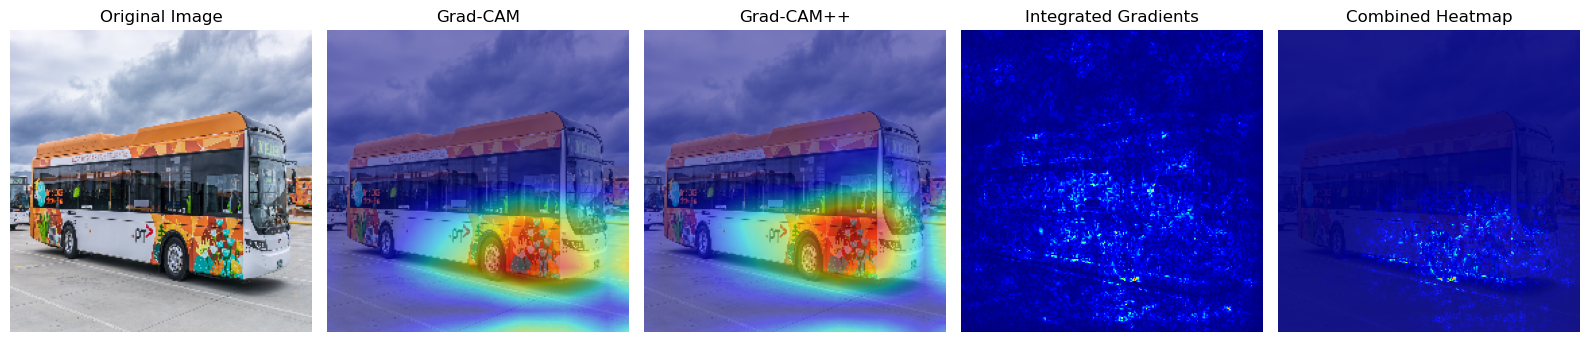

C:\Users\sanje\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\sanje\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\sanje\AppData\Local\Temp\ipykernel_10180\1500515021.py:248: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(representative_nodes))


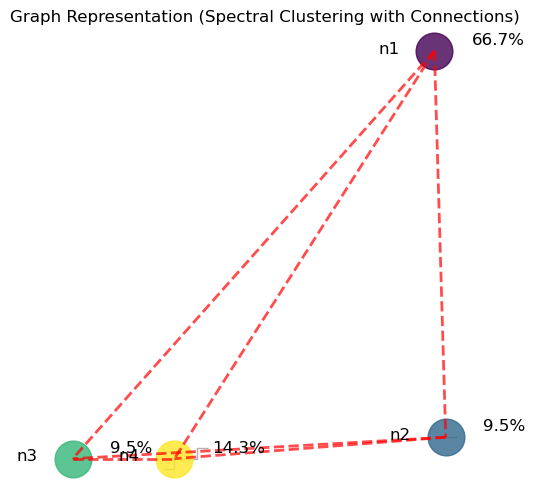

In [4]:
# =============================================================================
# Author: Pubudu Sanjeewani Thihagoda Gamage
# Date: 20-09-2024
# Title: A Novel Graph-Based Framework for Understanding of Decision-Making Process in Deep Learning Models
# License: MIT License
# =============================================================================

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import SpectralClustering
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
import numpy as np
from skimage.transform import resize

# Load pre-trained ResNet50V2 model with classification head (include_top=True)
model = ResNet50V2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

# Load and preprocess the image
img_path = 'images/bus.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Get predictions
predictions = model.predict(x)

# Decode the top 5 predictions
top_preds = decode_predictions(predictions, top=5)[0]

# Print top 5 predictions
for i, (imagenet_id, label, score) in enumerate(top_preds):
    print(f"{i+1}: {label} (score: {score:.4f})")

class_idx = 874

# Compute Grad-CAM
def compute_gradcam(model, img_array, class_idx):
    # Select a convolutional layer suitable for Grad-CAM visualization
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer('conv5_block3_out').output, model.output]  # Using the last convolutional block
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        tape.watch(conv_outputs)
        class_output = predictions[:, class_idx]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(conv_outputs * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)

    return heatmap

# Compute Grad-CAM++
def compute_gradcam_plus_plus(model, img_array, class_idx):
    # Select a convolutional layer suitable for Grad-CAM++ visualization
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer('conv5_block3_out').output, model.output]  # Using the last convolutional block
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        tape.watch(conv_outputs)
        class_output = predictions[:, class_idx]

    grads = tape.gradient(class_output, conv_outputs)
    grads = tf.maximum(grads, 0)  

    # Compute second order gradients
    with tf.GradientTape() as tape2:
        tape2.watch(conv_outputs)
        class_output = predictions[:, class_idx]

    second_grads = tape2.gradient(class_output, conv_outputs)

    # Compute the weights for Grad-CAM++
    weights = tf.reduce_sum(tf.divide(grads ** 2, 2 * grads + tf.keras.backend.epsilon()), axis=(0, 1))

    # Compute the Grad-CAM++ heatmap
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(weights * conv_outputs, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / tf.reduce_max(heatmap)  # Normalize the heatmap

    return heatmap.numpy()

# Compute Integrated Gradients
def compute_integrated_gradients(model, img_array, class_idx, baseline=None, num_steps=50):
    if baseline is None:
        baseline = np.zeros_like(img_array)

    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)
    baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)

    alphas = np.linspace(0, 1, num_steps)
    grads = np.zeros_like(img_array)

    for alpha in alphas:
        interpolated_img = baseline + alpha * (img_array - baseline)
        with tf.GradientTape() as tape:
            tape.watch(interpolated_img)
            predictions = model(interpolated_img)
            class_output = predictions[:, class_idx]
        grads += tape.gradient(class_output, interpolated_img)

    avg_grads = grads / num_steps
    integrated_gradients = (img_array - baseline) * avg_grads
    integrated_gradients = np.sum(np.abs(integrated_gradients), axis=-1)
    integrated_gradients = integrated_gradients / np.max(integrated_gradients)

    return integrated_gradients

# Compute heatmpas
gradcam_heatmap = compute_gradcam(model, x, class_idx)
gradcam_plus_plus_heatmap = compute_gradcam_plus_plus(model, x, class_idx)
integrated_gradients_map = compute_integrated_gradients(model, x, class_idx)

# Resize heatmaps to match image dimensions
gradcam_heatmap_resized = resize(gradcam_heatmap, (224, 224), mode='reflect', anti_aliasing=True)
gradcam_plus_plus_heatmap_resized = resize(gradcam_plus_plus_heatmap, (224, 224), mode='reflect', anti_aliasing=True)

# Combine heatmaps
combined_heatmap = gradcam_heatmap_resized * integrated_gradients_map
combined_heatmap = np.clip(combined_heatmap, 0, 1)

# Remove extra dimensions if present
combined_heatmap = np.squeeze(combined_heatmap)

# Plot all heatmaps 
plt.figure(figsize=(16, 8))

# Original image
plt.subplot(1, 5, 1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')

# Grad-CAM heatmap
plt.subplot(1, 5, 2)
plt.title('Grad-CAM')
plt.imshow(img)
plt.imshow(gradcam_heatmap_resized, cmap='jet', alpha=0.5)
plt.axis('off')

# Grad-CAM++ heatmap
plt.subplot(1, 5, 3)
plt.title('Grad-CAM++')
plt.imshow(img)
plt.imshow(gradcam_plus_plus_heatmap_resized, cmap='jet', alpha=0.5)
plt.axis('off')

# Integrated gradients map
plt.subplot(1, 5, 4)
plt.title('Integrated Gradients')
plt.imshow(integrated_gradients_map[0], cmap='jet')
plt.axis('off')

# Combined heatmap
plt.subplot(1, 5, 5)
plt.title('Combined Heatmap')
plt.imshow(img)
plt.imshow(np.squeeze(combined_heatmap), cmap='jet', alpha=0.9)  # Use np.squeeze to fix the shape
plt.axis('off')

plt.tight_layout()
plt.show()

# Create a graph from the combined heatmap
def create_graph_from_heatmap(heatmap, threshold=0.3):
    G = nx.Graph()
    height, width = heatmap.shape

    for i in range(height):
        for j in range(width):
            if heatmap[i, j] > threshold:  # Add nodes for heatmap values above threshold
                G.add_node((i, j), value=heatmap[i, j])
                # Connect to neighbors
                if i > 0 and heatmap[i-1, j] > threshold:  # Top neighbor
                    G.add_edge((i, j), (i-1, j))
                if j > 0 and heatmap[i, j-1] > threshold:  # Left neighbor
                    G.add_edge((i, j), (i, j-1))
                if i < height - 1 and heatmap[i+1, j] > threshold:  # Bottom neighbor
                    G.add_edge((i, j), (i+1, j))
                if j < width - 1 and heatmap[i, j+1] > threshold:  # Right neighbor
                    G.add_edge((i, j), (i, j+1))
    return G

# Function to cluster the graph using spectral clustering
def cluster_graph_spectral(G, n_clusters=4):
    adj_matrix = nx.to_numpy_array(G)
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
    labels = spectral.fit_predict(adj_matrix)
    partition = {node: label for node, label in zip(G.nodes(), labels)}
    return partition

# Create graph from the combined heatmap
G = create_graph_from_heatmap(combined_heatmap)

# Spectral clustering
partition_spectral = cluster_graph_spectral(G)

# Function to label only representative nodes as n1, n2, n3, etc.
def label_representative_nodes_as_n(representative_nodes):
    node_labels = {}
    for i, node in enumerate(representative_nodes):
        node_labels[node] = f'n{i+1}'  # Label representative nodes as n1, n2, ...
    return node_labels

# Function to visualize clustered graph with inter-cluster connections and correct node labels
def visualize_clustered_graph_with_connections_labeled(G, partition, title):
    plt.figure(figsize=(6, 6))
    pos = {(x, y): (y, -x) for x, y in G.nodes()}
    
    # Determine cluster sizes and representative nodes
    clusters = {}
    for node, cluster_id in partition.items():
        if cluster_id not in clusters:
            clusters[cluster_id] = []
        clusters[cluster_id].append(node)

    # Choose one representative node per cluster and calculate percentages
    representative_nodes = {}
    total_nodes = len(G.nodes())
    for cluster_id, nodes in clusters.items():
        representative_node = nodes[0]  # Select the first node as the representative
        representative_nodes[representative_node] = len(nodes) / total_nodes * 100  # Percentage of total nodes

    # Label only the representative nodes as n1, n2, n3, etc.
    node_labels = label_representative_nodes_as_n(representative_nodes)

    # Draw edges first
    nx.draw_networkx_edges(G, pos, alpha=0.3)

    # Draw nodes
    cmap = cm.get_cmap('viridis', len(representative_nodes))
    node_colors = [cmap(i) for i in range(len(representative_nodes))]
    for idx, (node, percentage) in enumerate(representative_nodes.items()):
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_size=700, node_color=[node_colors[idx]], alpha=0.8)
        
        # Shift the node labels slightly away from the nodes
        label_x_offset = -4  # Adjust this value to shift horizontally
        label_y_offset = 0.2  # Adjust this value to shift vertically

        # Annotate representative node with name (n1, n2, etc.)
        plt.text(pos[node][0] + label_x_offset, pos[node][1] + label_y_offset, node_labels[node],
                 fontsize=12, ha='center', va='center', color='black')
        
        # Shift the percentage values slightly further away from the node
        percentage_x_offset = 3.3  # Increase this to move the text further away horizontally
        percentage_y_offset = 1  # Increase this to move the text further away vertically

        # Annotate with percentage value next to the node
        plt.text(pos[node][0] + percentage_x_offset, pos[node][1] + percentage_y_offset, f'{percentage:.1f}%',
                 fontsize=12, ha='left', va='center')

    # Add inter-cluster connections (edges between representative nodes)
    for i, rep_node_1 in enumerate(representative_nodes):
        for j, rep_node_2 in enumerate(representative_nodes):
            if i < j:  # To avoid double-drawing edges
                plt.plot(
                    [pos[rep_node_1][0], pos[rep_node_2][0]], 
                    [pos[rep_node_1][1], pos[rep_node_2][1]], 
                    color='red', linestyle='--', linewidth=2, alpha=0.7
                )

    plt.title(title)
    plt.axis('off')
    plt.show()

# Function to visualize the spectral clustering with connections and labeled nodes
visualize_clustered_graph_with_connections_labeled(G, partition_spectral, 'Graph Representation (Spectral Clustering with Connections)')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1: ambulance (score: 0.9998)
2: police_van (score: 0.0002)
3: minibus (score: 0.0000)
4: cab (score: 0.0000)
5: moving_van (score: 0.0000)


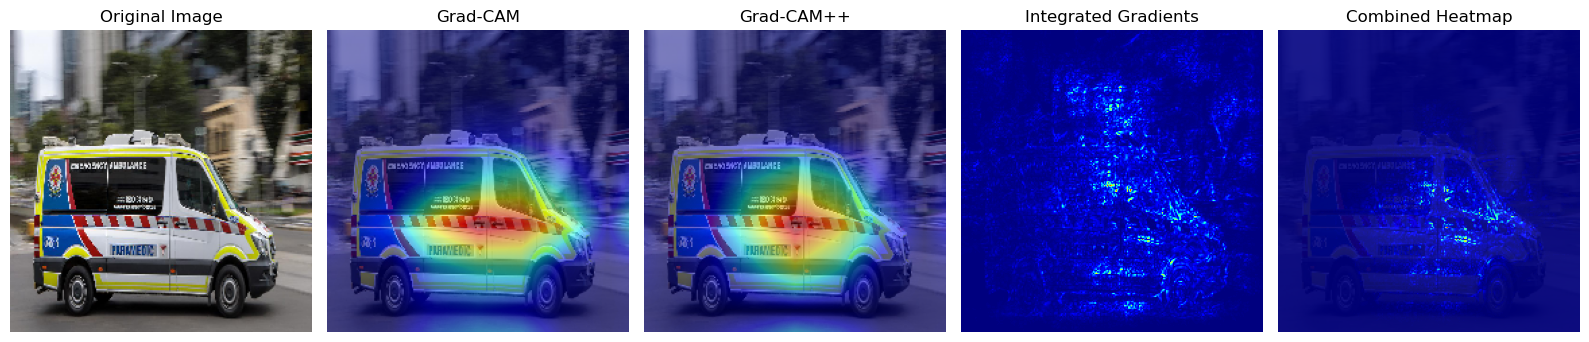

C:\Users\sanje\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\sanje\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\sanje\AppData\Local\Temp\ipykernel_10180\3192968232.py:248: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(representative_nodes))


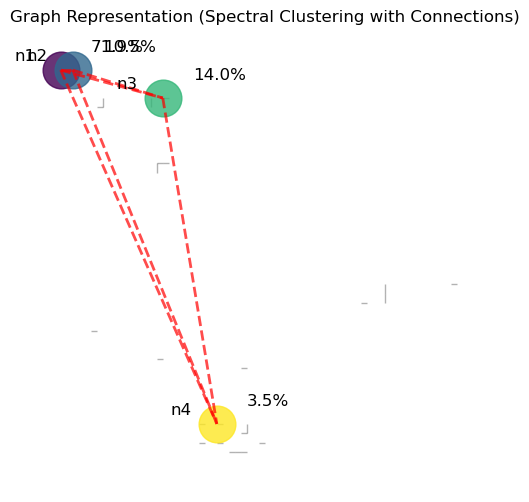

In [5]:
# =============================================================================
# Author: Pubudu Sanjeewani Thihagoda Gamage
# Date: 20-09-2024
# Title: A Novel Graph-Based Framework for Understanding of Decision-Making Process in Deep Learning Models
# License: MIT License
# =============================================================================

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import SpectralClustering
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
import numpy as np
from skimage.transform import resize

# Load pre-trained ResNet50V2 model with classification head (include_top=True)
model = ResNet50V2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

# Load and preprocess the image
img_path = 'images/ambulance.jpeg'  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Get predictions
predictions = model.predict(x)

# Decode the top 5 predictions
top_preds = decode_predictions(predictions, top=5)[0]

# Print top 5 predictions
for i, (imagenet_id, label, score) in enumerate(top_preds):
    print(f"{i+1}: {label} (score: {score:.4f})")

class_idx = 407

# Compute Grad-CAM
def compute_gradcam(model, img_array, class_idx):
    # Select a convolutional layer suitable for Grad-CAM visualization
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer('conv5_block3_out').output, model.output]  # Using the last convolutional block
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        tape.watch(conv_outputs)
        class_output = predictions[:, class_idx]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(conv_outputs * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)

    return heatmap

# Compute Grad-CAM++
def compute_gradcam_plus_plus(model, img_array, class_idx):
    # Select a convolutional layer suitable for Grad-CAM++ visualization
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer('conv5_block3_out').output, model.output]  # Using the last convolutional block
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        tape.watch(conv_outputs)
        class_output = predictions[:, class_idx]

    grads = tape.gradient(class_output, conv_outputs)
    grads = tf.maximum(grads, 0)  

    # Compute second order gradients
    with tf.GradientTape() as tape2:
        tape2.watch(conv_outputs)
        class_output = predictions[:, class_idx]

    second_grads = tape2.gradient(class_output, conv_outputs)

    # Compute the weights for Grad-CAM++
    weights = tf.reduce_sum(tf.divide(grads ** 2, 2 * grads + tf.keras.backend.epsilon()), axis=(0, 1))

    # Compute the Grad-CAM++ heatmap
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(weights * conv_outputs, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / tf.reduce_max(heatmap)  # Normalize the heatmap

    return heatmap.numpy()

# Compute Integrated Gradients
def compute_integrated_gradients(model, img_array, class_idx, baseline=None, num_steps=50):
    if baseline is None:
        baseline = np.zeros_like(img_array)

    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)
    baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)

    alphas = np.linspace(0, 1, num_steps)
    grads = np.zeros_like(img_array)

    for alpha in alphas:
        interpolated_img = baseline + alpha * (img_array - baseline)
        with tf.GradientTape() as tape:
            tape.watch(interpolated_img)
            predictions = model(interpolated_img)
            class_output = predictions[:, class_idx]
        grads += tape.gradient(class_output, interpolated_img)

    avg_grads = grads / num_steps
    integrated_gradients = (img_array - baseline) * avg_grads
    integrated_gradients = np.sum(np.abs(integrated_gradients), axis=-1)
    integrated_gradients = integrated_gradients / np.max(integrated_gradients)

    return integrated_gradients

# Compute heatmaps
gradcam_heatmap = compute_gradcam(model, x, class_idx)
gradcam_plus_plus_heatmap = compute_gradcam_plus_plus(model, x, class_idx)
integrated_gradients_map = compute_integrated_gradients(model, x, class_idx)

# Resize heatmaps to match image dimensions
gradcam_heatmap_resized = resize(gradcam_heatmap, (224, 224), mode='reflect', anti_aliasing=True)
gradcam_plus_plus_heatmap_resized = resize(gradcam_plus_plus_heatmap, (224, 224), mode='reflect', anti_aliasing=True)

# Combine heatmaps
combined_heatmap = gradcam_heatmap_resized * integrated_gradients_map
combined_heatmap = np.clip(combined_heatmap, 0, 1)

# Remove extra dimensions if present
combined_heatmap = np.squeeze(combined_heatmap)

# Plot all heatmaps 
plt.figure(figsize=(16, 8))

# Original image
plt.subplot(1, 5, 1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')

# Grad-CAM heatmap
plt.subplot(1, 5, 2)
plt.title('Grad-CAM')
plt.imshow(img)
plt.imshow(gradcam_heatmap_resized, cmap='jet', alpha=0.5)
plt.axis('off')

# Grad-CAM++ heatmap
plt.subplot(1, 5, 3)
plt.title('Grad-CAM++')
plt.imshow(img)
plt.imshow(gradcam_plus_plus_heatmap_resized, cmap='jet', alpha=0.5)
plt.axis('off')

# Integrated gradients map
plt.subplot(1, 5, 4)
plt.title('Integrated Gradients')
plt.imshow(integrated_gradients_map[0], cmap='jet')
plt.axis('off')

# Combined heatmap
plt.subplot(1, 5, 5)
plt.title('Combined Heatmap')
plt.imshow(img)
plt.imshow(np.squeeze(combined_heatmap), cmap='jet', alpha=0.9)  # Use np.squeeze to fix the shape
plt.axis('off')

plt.tight_layout()
plt.show()

# Create a graph from the combined heatmap
def create_graph_from_heatmap(heatmap, threshold=0.3):
    G = nx.Graph()
    height, width = heatmap.shape

    for i in range(height):
        for j in range(width):
            if heatmap[i, j] > threshold:  # Add nodes for heatmap values above threshold
                G.add_node((i, j), value=heatmap[i, j])
                # Connect to neighbors
                if i > 0 and heatmap[i-1, j] > threshold:  # Top neighbor
                    G.add_edge((i, j), (i-1, j))
                if j > 0 and heatmap[i, j-1] > threshold:  # Left neighbor
                    G.add_edge((i, j), (i, j-1))
                if i < height - 1 and heatmap[i+1, j] > threshold:  # Bottom neighbor
                    G.add_edge((i, j), (i+1, j))
                if j < width - 1 and heatmap[i, j+1] > threshold:  # Right neighbor
                    G.add_edge((i, j), (i, j+1))
    return G

# Function to cluster the graph using spectral clustering
def cluster_graph_spectral(G, n_clusters=4):
    adj_matrix = nx.to_numpy_array(G)
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
    labels = spectral.fit_predict(adj_matrix)
    partition = {node: label for node, label in zip(G.nodes(), labels)}
    return partition

# Create graph from the combined heatmap
G = create_graph_from_heatmap(combined_heatmap)

# Spectral clustering
partition_spectral = cluster_graph_spectral(G)

# Function to label only representative nodes as n1, n2, n3, etc.
def label_representative_nodes_as_n(representative_nodes):
    node_labels = {}
    for i, node in enumerate(representative_nodes):
        node_labels[node] = f'n{i+1}'  # Label representative nodes as n1, n2, ...
    return node_labels

# Function to visualize clustered graph with inter-cluster connections and correct node labels
def visualize_clustered_graph_with_connections_labeled(G, partition, title):
    plt.figure(figsize=(6, 6))
    pos = {(x, y): (y, -x) for x, y in G.nodes()}
    
    # Determine cluster sizes and representative nodes
    clusters = {}
    for node, cluster_id in partition.items():
        if cluster_id not in clusters:
            clusters[cluster_id] = []
        clusters[cluster_id].append(node)

    # Choose one representative node per cluster and calculate percentages
    representative_nodes = {}
    total_nodes = len(G.nodes())
    for cluster_id, nodes in clusters.items():
        representative_node = nodes[0]  # Select the first node as the representative
        representative_nodes[representative_node] = len(nodes) / total_nodes * 100  # Percentage of total nodes

    # Label only the representative nodes as n1, n2, n3, etc.
    node_labels = label_representative_nodes_as_n(representative_nodes)

    # Draw edges first
    nx.draw_networkx_edges(G, pos, alpha=0.3)

    # Draw nodes
    cmap = cm.get_cmap('viridis', len(representative_nodes))
    node_colors = [cmap(i) for i in range(len(representative_nodes))]
    for idx, (node, percentage) in enumerate(representative_nodes.items()):
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_size=700, node_color=[node_colors[idx]], alpha=0.8)
        
        # Shift the node labels slightly away from the nodes
        label_x_offset = -6  # Adjust this value to shift horizontally
        label_y_offset = 1.5  # Adjust this value to shift vertically

        # Annotate representative node with name (n1, n2, etc.)
        plt.text(pos[node][0] + label_x_offset, pos[node][1] + label_y_offset, node_labels[node],
                 fontsize=12, ha='center', va='center', color='black')
        
        # Shift the percentage values slightly further away from the node
        percentage_x_offset = 5  # Increase this to move the text further away horizontally
        percentage_y_offset = 2.5  # Increase this to move the text further away vertically

        # Annotate with percentage value next to the node
        plt.text(pos[node][0] + percentage_x_offset, pos[node][1] + percentage_y_offset, f'{percentage:.1f}%',
                 fontsize=12, ha='left', va='center')

    # Add inter-cluster connections (edges between representative nodes)
    for i, rep_node_1 in enumerate(representative_nodes):
        for j, rep_node_2 in enumerate(representative_nodes):
            if i < j:  # To avoid double-drawing edges
                plt.plot(
                    [pos[rep_node_1][0], pos[rep_node_2][0]], 
                    [pos[rep_node_1][1], pos[rep_node_2][1]], 
                    color='red', linestyle='--', linewidth=2, alpha=0.7
                )

    plt.title(title)
    plt.axis('off')
    plt.show()

# Function to visualize the Spectral Clustering with connections and labeled nodes
visualize_clustered_graph_with_connections_labeled(G, partition_spectral, 'Graph Representation (Spectral Clustering with Connections)')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1: cheetah (score: 0.9866)
2: leopard (score: 0.0131)
3: jaguar (score: 0.0004)
4: accordion (score: 0.0000)
5: snow_leopard (score: 0.0000)


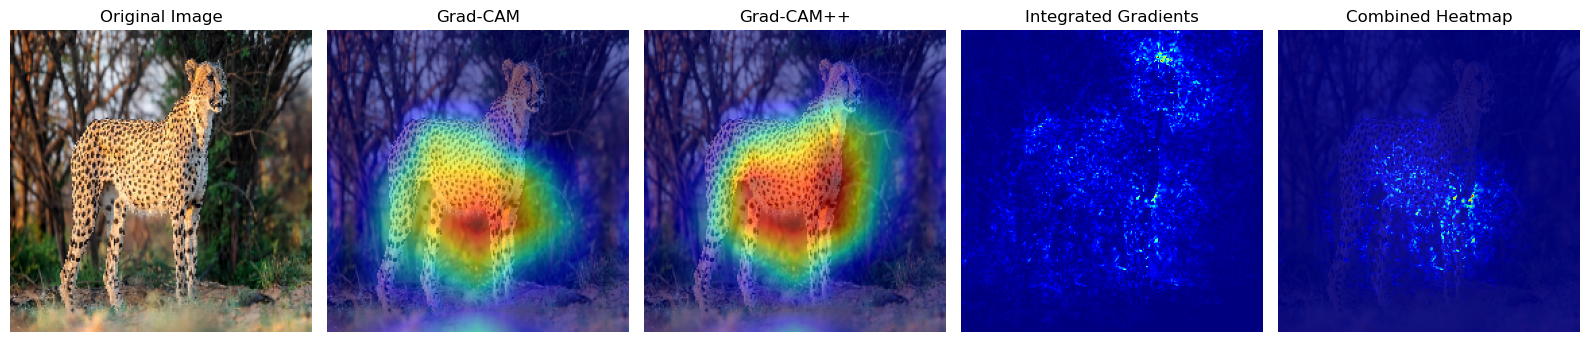

C:\Users\sanje\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\sanje\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\sanje\AppData\Local\Temp\ipykernel_10180\2246756850.py:248: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(representative_nodes))


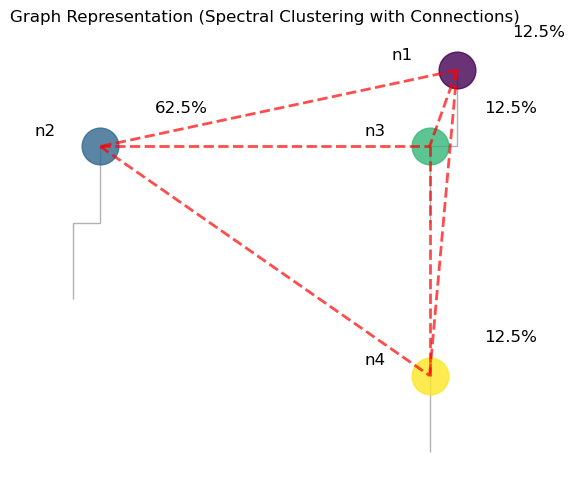

In [6]:
# =============================================================================
# Author: Pubudu Sanjeewani Thihagoda Gamage
# Date: 20-09-2024
# Title: A Novel Graph-Based Framework for Understanding of Decision-Making Process in Deep Learning Models
# License: MIT License
# =============================================================================

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import SpectralClustering
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
import numpy as np
from skimage.transform import resize

# Load pre-trained ResNet50V2 model with classification head (include_top=True)
model = ResNet50V2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

# Load and preprocess the image
img_path = 'images/cheetah.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Get predictions
predictions = model.predict(x)

# Decode the top 5 predictions
top_preds = decode_predictions(predictions, top=5)[0]

# Print top 5 predictions
for i, (imagenet_id, label, score) in enumerate(top_preds):
    print(f"{i+1}: {label} (score: {score:.4f})")

class_idx = 293

# Compute Grad-CAM
def compute_gradcam(model, img_array, class_idx):
    # Select a convolutional layer suitable for Grad-CAM visualization
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer('conv5_block3_out').output, model.output]  # Using the last convolutional block
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        tape.watch(conv_outputs)
        class_output = predictions[:, class_idx]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(conv_outputs * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)

    return heatmap

# Compute Grad-CAM++
def compute_gradcam_plus_plus(model, img_array, class_idx):
    # Select a convolutional layer suitable for Grad-CAM++ visualization
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer('conv5_block3_out').output, model.output]  # Using the last convolutional block
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        tape.watch(conv_outputs)
        class_output = predictions[:, class_idx]

    grads = tape.gradient(class_output, conv_outputs)
    grads = tf.maximum(grads, 0)  

    # Compute second order gradients
    with tf.GradientTape() as tape2:
        tape2.watch(conv_outputs)
        class_output = predictions[:, class_idx]

    second_grads = tape2.gradient(class_output, conv_outputs)

    # Compute the weights for Grad-CAM++
    weights = tf.reduce_sum(tf.divide(grads ** 2, 2 * grads + tf.keras.backend.epsilon()), axis=(0, 1))

    # Compute the Grad-CAM++ heatmap
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(weights * conv_outputs, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / tf.reduce_max(heatmap)  # Normalize the heatmap

    return heatmap.numpy()

# Compute Integrated Gradients
def compute_integrated_gradients(model, img_array, class_idx, baseline=None, num_steps=50):
    if baseline is None:
        baseline = np.zeros_like(img_array)

    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)
    baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)

    alphas = np.linspace(0, 1, num_steps)
    grads = np.zeros_like(img_array)

    for alpha in alphas:
        interpolated_img = baseline + alpha * (img_array - baseline)
        with tf.GradientTape() as tape:
            tape.watch(interpolated_img)
            predictions = model(interpolated_img)
            class_output = predictions[:, class_idx]
        grads += tape.gradient(class_output, interpolated_img)

    avg_grads = grads / num_steps
    integrated_gradients = (img_array - baseline) * avg_grads
    integrated_gradients = np.sum(np.abs(integrated_gradients), axis=-1)
    integrated_gradients = integrated_gradients / np.max(integrated_gradients)

    return integrated_gradients

# Compute heatmaps
gradcam_heatmap = compute_gradcam(model, x, class_idx)
gradcam_plus_plus_heatmap = compute_gradcam_plus_plus(model, x, class_idx)
integrated_gradients_map = compute_integrated_gradients(model, x, class_idx)

# Resize heatmaps to match image dimensions
gradcam_heatmap_resized = resize(gradcam_heatmap, (224, 224), mode='reflect', anti_aliasing=True)
gradcam_plus_plus_heatmap_resized = resize(gradcam_plus_plus_heatmap, (224, 224), mode='reflect', anti_aliasing=True)

# Combine heatmaps
combined_heatmap = gradcam_heatmap_resized * integrated_gradients_map
combined_heatmap = np.clip(combined_heatmap, 0, 1)

# Remove extra dimensions if present
combined_heatmap = np.squeeze(combined_heatmap)

# Plot all heatmaps 
plt.figure(figsize=(16, 8))

# Original image
plt.subplot(1, 5, 1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')

# Grad-CAM heatmap
plt.subplot(1, 5, 2)
plt.title('Grad-CAM')
plt.imshow(img)
plt.imshow(gradcam_heatmap_resized, cmap='jet', alpha=0.5)
plt.axis('off')

# Grad-CAM++ heatmap
plt.subplot(1, 5, 3)
plt.title('Grad-CAM++')
plt.imshow(img)
plt.imshow(gradcam_plus_plus_heatmap_resized, cmap='jet', alpha=0.5)
plt.axis('off')

# Integrated gradients map
plt.subplot(1, 5, 4)
plt.title('Integrated Gradients')
plt.imshow(integrated_gradients_map[0], cmap='jet')
plt.axis('off')

# Combined heatmap
plt.subplot(1, 5, 5)
plt.title('Combined Heatmap')
plt.imshow(img)
plt.imshow(np.squeeze(combined_heatmap), cmap='jet', alpha=0.9)  # Use np.squeeze to fix the shape
plt.axis('off')

plt.tight_layout()
plt.show()

# Create a graph from the combined heatmap
def create_graph_from_heatmap(heatmap, threshold=0.3):
    G = nx.Graph()
    height, width = heatmap.shape

    for i in range(height):
        for j in range(width):
            if heatmap[i, j] > threshold:  # Add nodes for heatmap values above threshold
                G.add_node((i, j), value=heatmap[i, j])
                # Connect to neighbors
                if i > 0 and heatmap[i-1, j] > threshold:  # Top neighbor
                    G.add_edge((i, j), (i-1, j))
                if j > 0 and heatmap[i, j-1] > threshold:  # Left neighbor
                    G.add_edge((i, j), (i, j-1))
                if i < height - 1 and heatmap[i+1, j] > threshold:  # Bottom neighbor
                    G.add_edge((i, j), (i+1, j))
                if j < width - 1 and heatmap[i, j+1] > threshold:  # Right neighbor
                    G.add_edge((i, j), (i, j+1))
    return G

# Function to cluster the graph using spectral clustering
def cluster_graph_spectral(G, n_clusters=4):
    adj_matrix = nx.to_numpy_array(G)
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
    labels = spectral.fit_predict(adj_matrix)
    partition = {node: label for node, label in zip(G.nodes(), labels)}
    return partition

# Create graph from the combined heatmap
G = create_graph_from_heatmap(combined_heatmap)

# Spectral clustering
partition_spectral = cluster_graph_spectral(G)

# Function to label only representative nodes as n1, n2, n3, etc.
def label_representative_nodes_as_n(representative_nodes):
    node_labels = {}
    for i, node in enumerate(representative_nodes):
        node_labels[node] = f'n{i+1}'  # Label representative nodes as n1, n2, ...
    return node_labels

# Function to visualize clustered graph with inter-cluster connections and correct node labels
def visualize_clustered_graph_with_connections_labeled(G, partition, title):
    plt.figure(figsize=(6, 6))
    pos = {(x, y): (y, -x) for x, y in G.nodes()}
    
    # Determine cluster sizes and representative nodes
    clusters = {}
    for node, cluster_id in partition.items():
        if cluster_id not in clusters:
            clusters[cluster_id] = []
        clusters[cluster_id].append(node)

    # Choose one representative node per cluster and calculate percentages
    representative_nodes = {}
    total_nodes = len(G.nodes())
    for cluster_id, nodes in clusters.items():
        representative_node = nodes[0]  # Select the first node as the representative
        representative_nodes[representative_node] = len(nodes) / total_nodes * 100  # Percentage of total nodes

    # Label only the representative nodes as n1, n2, n3, etc.
    node_labels = label_representative_nodes_as_n(representative_nodes)

    # Draw edges first
    nx.draw_networkx_edges(G, pos, alpha=0.3)

    # Draw nodes
    cmap = cm.get_cmap('viridis', len(representative_nodes))
    node_colors = [cmap(i) for i in range(len(representative_nodes))]
    for idx, (node, percentage) in enumerate(representative_nodes.items()):
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_size=700, node_color=[node_colors[idx]], alpha=0.8)
        
        # Shift the node labels slightly away from the nodes
        label_x_offset = -2  # Adjust this value to shift horizontally
        label_y_offset = 0.2  # Adjust this value to shift vertically

        # Annotate representative node with name (n1, n2, etc.)
        plt.text(pos[node][0] + label_x_offset, pos[node][1] + label_y_offset, node_labels[node],
                 fontsize=12, ha='center', va='center', color='black')
        
        # Shift the percentage values slightly further away from the node
        percentage_x_offset = 2  # Increase this to move the text further away horizontally
        percentage_y_offset = 0.5  # Increase this to move the text further away vertically

        # Annotate with percentage value next to the node
        plt.text(pos[node][0] + percentage_x_offset, pos[node][1] + percentage_y_offset, f'{percentage:.1f}%',
                 fontsize=12, ha='left', va='center')

    # Add inter-cluster connections (edges between representative nodes)
    for i, rep_node_1 in enumerate(representative_nodes):
        for j, rep_node_2 in enumerate(representative_nodes):
            if i < j:  # To avoid double-drawing edges
                plt.plot(
                    [pos[rep_node_1][0], pos[rep_node_2][0]], 
                    [pos[rep_node_1][1], pos[rep_node_2][1]], 
                    color='red', linestyle='--', linewidth=2, alpha=0.7
                )

    plt.title(title)
    plt.axis('off')
    plt.show()

# Function to visualize the Spectral Clustering with connections and labeled nodes
visualize_clustered_graph_with_connections_labeled(G, partition_spectral, 'Graph Representation (Spectral Clustering with Connections)')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1: cab (score: 0.4854)
2: school_bus (score: 0.4248)
3: racer (score: 0.0699)
4: lifeboat (score: 0.0094)
5: sports_car (score: 0.0037)


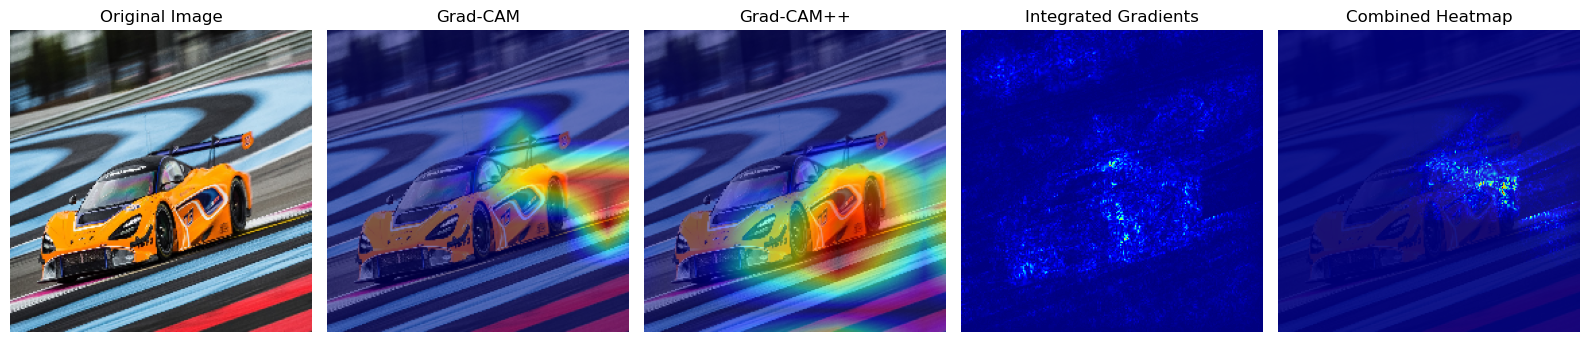

C:\Users\sanje\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\sanje\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\sanje\AppData\Local\Temp\ipykernel_10180\1380522074.py:248: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(representative_nodes))


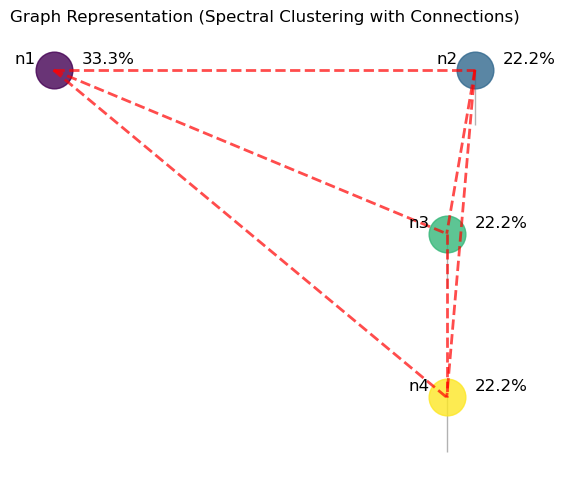

In [7]:
# =============================================================================
# Author: Pubudu Sanjeewani Thihagoda Gamage
# Date: 20-09-2024
# Title: A Novel Graph-Based Framework for Understanding of Decision-Making Process in Deep Learning Models
# License: MIT License
# =============================================================================

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import SpectralClustering
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
import numpy as np
from skimage.transform import resize

# Load pre-trained ResNet50V2 model with classification head (include_top=True)
model = ResNet50V2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

# Load and preprocess the image
img_path = 'images/racing car.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Get predictions
predictions = model.predict(x)

# Decode the top 5 predictions
top_preds = decode_predictions(predictions, top=5)[0]

# Print top 5 predictions
for i, (imagenet_id, label, score) in enumerate(top_preds):
    print(f"{i+1}: {label} (score: {score:.4f})")

class_idx = 751

# Compute Grad-CAM
def compute_gradcam(model, img_array, class_idx):
    # Select a convolutional layer suitable for Grad-CAM visualization
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer('conv5_block3_out').output, model.output]  # Using the last convolutional block
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        tape.watch(conv_outputs)
        class_output = predictions[:, class_idx]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(conv_outputs * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)

    return heatmap

# Compute Grad-CAM++
def compute_gradcam_plus_plus(model, img_array, class_idx):
    # Select a convolutional layer suitable for Grad-CAM++ visualization
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer('conv5_block3_out').output, model.output]  # Using the last convolutional block
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        tape.watch(conv_outputs)
        class_output = predictions[:, class_idx]

    grads = tape.gradient(class_output, conv_outputs)
    grads = tf.maximum(grads, 0) 

    # Compute second order gradients
    with tf.GradientTape() as tape2:
        tape2.watch(conv_outputs)
        class_output = predictions[:, class_idx]

    second_grads = tape2.gradient(class_output, conv_outputs)

    # Compute the weights for Grad-CAM++
    weights = tf.reduce_sum(tf.divide(grads ** 2, 2 * grads + tf.keras.backend.epsilon()), axis=(0, 1))

    # Compute the Grad-CAM++ heatmap
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(weights * conv_outputs, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / tf.reduce_max(heatmap)  # Normalize the heatmap

    return heatmap.numpy()

# Compute Integrated Gradients
def compute_integrated_gradients(model, img_array, class_idx, baseline=None, num_steps=50):
    if baseline is None:
        baseline = np.zeros_like(img_array)

    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)
    baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)

    alphas = np.linspace(0, 1, num_steps)
    grads = np.zeros_like(img_array)

    for alpha in alphas:
        interpolated_img = baseline + alpha * (img_array - baseline)
        with tf.GradientTape() as tape:
            tape.watch(interpolated_img)
            predictions = model(interpolated_img)
            class_output = predictions[:, class_idx]
        grads += tape.gradient(class_output, interpolated_img)

    avg_grads = grads / num_steps
    integrated_gradients = (img_array - baseline) * avg_grads
    integrated_gradients = np.sum(np.abs(integrated_gradients), axis=-1)
    integrated_gradients = integrated_gradients / np.max(integrated_gradients)

    return integrated_gradients

# Compute heatmaps
gradcam_heatmap = compute_gradcam(model, x, class_idx)
gradcam_plus_plus_heatmap = compute_gradcam_plus_plus(model, x, class_idx)
integrated_gradients_map = compute_integrated_gradients(model, x, class_idx)

# Resize heatmaps to match image dimensions
gradcam_heatmap_resized = resize(gradcam_heatmap, (224, 224), mode='reflect', anti_aliasing=True)
gradcam_plus_plus_heatmap_resized = resize(gradcam_plus_plus_heatmap, (224, 224), mode='reflect', anti_aliasing=True)

# Combine heatmaps
combined_heatmap = gradcam_heatmap_resized * integrated_gradients_map
combined_heatmap = np.clip(combined_heatmap, 0, 1)

# Remove extra dimensions if present
combined_heatmap = np.squeeze(combined_heatmap)

# Plot all heatmaps including Grad-CAM++
plt.figure(figsize=(16, 8))

# Original image
plt.subplot(1, 5, 1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')

# Grad-CAM heatmap
plt.subplot(1, 5, 2)
plt.title('Grad-CAM')
plt.imshow(img)
plt.imshow(gradcam_heatmap_resized, cmap='jet', alpha=0.5)
plt.axis('off')

# Grad-CAM++ heatmap
plt.subplot(1, 5, 3)
plt.title('Grad-CAM++')
plt.imshow(img)
plt.imshow(gradcam_plus_plus_heatmap_resized, cmap='jet', alpha=0.5)
plt.axis('off')

# Integrated gradients map
plt.subplot(1, 5, 4)
plt.title('Integrated Gradients')
plt.imshow(integrated_gradients_map[0], cmap='jet')
plt.axis('off')

# Combined heatmap
plt.subplot(1, 5, 5)
plt.title('Combined Heatmap')
plt.imshow(img)
plt.imshow(np.squeeze(combined_heatmap), cmap='jet', alpha=0.9)  # Use np.squeeze to fix the shape
plt.axis('off')

plt.tight_layout()
plt.show()

# Create a graph from the combined heatmap
def create_graph_from_heatmap(heatmap, threshold=0.2):
    G = nx.Graph()
    height, width = heatmap.shape

    for i in range(height):
        for j in range(width):
            if heatmap[i, j] > threshold:  # Add nodes for heatmap values above threshold
                G.add_node((i, j), value=heatmap[i, j])
                # Connect to neighbors
                if i > 0 and heatmap[i-1, j] > threshold:  # Top neighbor
                    G.add_edge((i, j), (i-1, j))
                if j > 0 and heatmap[i, j-1] > threshold:  # Left neighbor
                    G.add_edge((i, j), (i, j-1))
                if i < height - 1 and heatmap[i+1, j] > threshold:  # Bottom neighbor
                    G.add_edge((i, j), (i+1, j))
                if j < width - 1 and heatmap[i, j+1] > threshold:  # Right neighbor
                    G.add_edge((i, j), (i, j+1))
    return G

# Function to cluster the graph using spectral clustering
def cluster_graph_spectral(G, n_clusters=4):
    adj_matrix = nx.to_numpy_array(G)
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
    labels = spectral.fit_predict(adj_matrix)
    partition = {node: label for node, label in zip(G.nodes(), labels)}
    return partition

# Create graph from the combined heatmap
G = create_graph_from_heatmap(combined_heatmap)

# Spectral clustering
partition_spectral = cluster_graph_spectral(G)

# Function to label only representative nodes as n1, n2, n3, etc.
def label_representative_nodes_as_n(representative_nodes):
    node_labels = {}
    for i, node in enumerate(representative_nodes):
        node_labels[node] = f'n{i+1}'  # Label representative nodes as n1, n2, ...
    return node_labels

# Function to visualize clustered graph with inter-cluster connections and correct node labels
def visualize_clustered_graph_with_connections_labeled(G, partition, title):
    plt.figure(figsize=(6, 6))
    pos = {(x, y): (y, -x) for x, y in G.nodes()}
    
    # Determine cluster sizes and representative nodes
    clusters = {}
    for node, cluster_id in partition.items():
        if cluster_id not in clusters:
            clusters[cluster_id] = []
        clusters[cluster_id].append(node)

    # Choose one representative node per cluster and calculate percentages
    representative_nodes = {}
    total_nodes = len(G.nodes())
    for cluster_id, nodes in clusters.items():
        representative_node = nodes[0]  # Select the first node as the representative
        representative_nodes[representative_node] = len(nodes) / total_nodes * 100  # Percentage of total nodes

    # Label only the representative nodes as n1, n2, n3, etc.
    node_labels = label_representative_nodes_as_n(representative_nodes)

    # Draw edges first
    nx.draw_networkx_edges(G, pos, alpha=0.3)

    # Draw nodes
    cmap = cm.get_cmap('viridis', len(representative_nodes))
    node_colors = [cmap(i) for i in range(len(representative_nodes))]
    for idx, (node, percentage) in enumerate(representative_nodes.items()):
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_size=700, node_color=[node_colors[idx]], alpha=0.8)
        
        # Shift the node labels slightly away from the nodes
        label_x_offset = -1  # Adjust this value to shift horizontally
        label_y_offset = 0.2  # Adjust this value to shift vertically

        # Annotate representative node with name (n1, n2, etc.)
        plt.text(pos[node][0] + label_x_offset, pos[node][1] + label_y_offset, node_labels[node],
                 fontsize=12, ha='center', va='center', color='black')
        
        # Shift the percentage values slightly further away from the node
        percentage_x_offset = 1  # Increase this to move the text further away horizontally
        percentage_y_offset = 0.2  # Increase this to move the text further away vertically

        # Annotate with percentage value next to the node
        plt.text(pos[node][0] + percentage_x_offset, pos[node][1] + percentage_y_offset, f'{percentage:.1f}%',
                 fontsize=12, ha='left', va='center')

    # Add inter-cluster connections (edges between representative nodes)
    for i, rep_node_1 in enumerate(representative_nodes):
        for j, rep_node_2 in enumerate(representative_nodes):
            if i < j:  # To avoid double-drawing edges
                plt.plot(
                    [pos[rep_node_1][0], pos[rep_node_2][0]], 
                    [pos[rep_node_1][1], pos[rep_node_2][1]], 
                    color='red', linestyle='--', linewidth=2, alpha=0.7
                )

    plt.title(title)
    plt.axis('off')
    plt.show()

# Function to visualize the Spectral Clustering with connections and labeled nodes
visualize_clustered_graph_with_connections_labeled(G, partition_spectral, 'Graph Representation (Spectral Clustering with Connections)')